In [ ]:
import matplotlib.pyplot as plt

import optuna
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from datasets import LaserDataset
from models import MLP, ExtendedMLP, LSTM, TimeSeriesCNN
from utils import train_model, hypertune_objective, generate_predictions, generate_predictions_with_train_fit, final_model_evaluation
from nbeats import NBeats


/Users/karolrogozinski/Studies/Deep Learning/ml_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


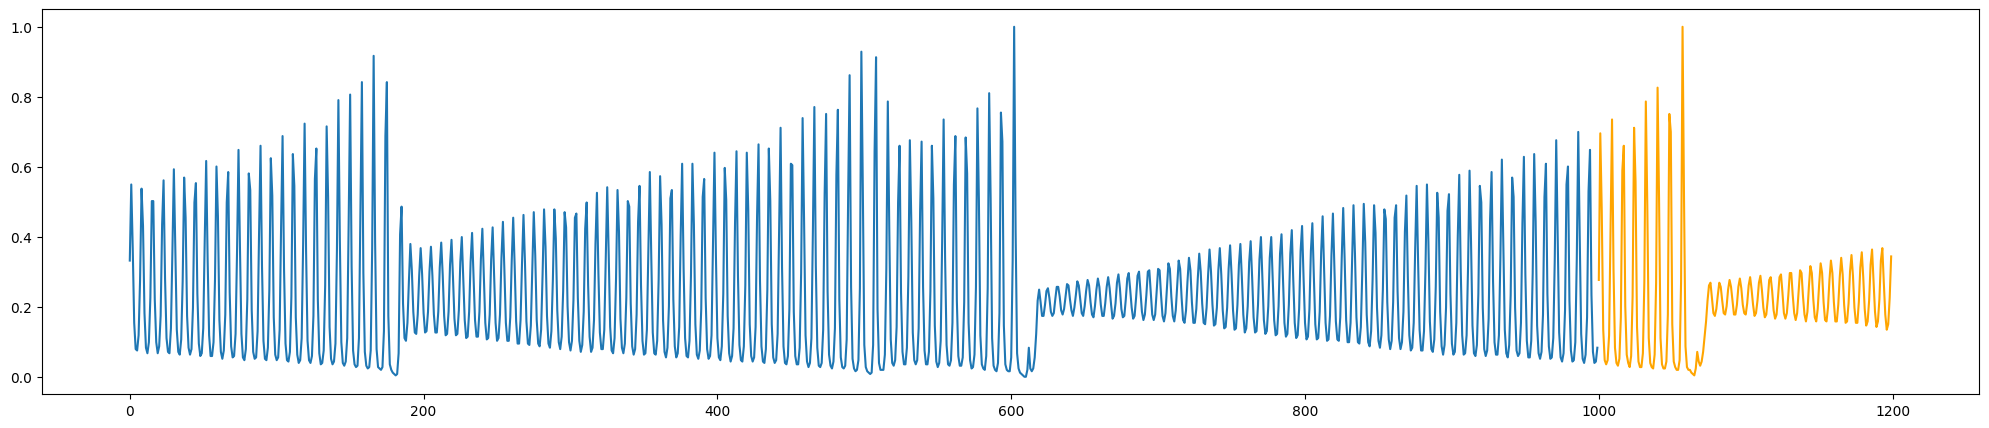

In [2]:
train_data = sio.loadmat('../data/Xtrain.mat')['Xtrain']
test_data = sio.loadmat('../data/Xtest.mat')['Xtest']

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

plt.figure(figsize=(25, 5))
plt.plot(train_data.flatten())
plt.plot(
    range(len(train_data), len(train_data) + len(test_data)), 
    test_data.flatten(), label='Test', color='orange'
)


In [3]:
def add_noise(x: torch.Tensor, noise_level=0.01):
    noise = torch.randn_like(x) * noise_level
    return x + noise


In [4]:
batch_size = len(train_data) # just feed with all data
epochs = 50

loss_fn = nn.MSELoss()

model_cls = NBeats
optim_cls = torch.optim.Adam
dataset_cls = LaserDataset

transforms = [
    lambda x: add_noise(x, noise_level=0.05)
]

def suggest_hyperparameters(trial):
    # Data hyperparameters
    data_params = {
        'window_size': trial.suggest_int('window_size', 50, 150)
    }
    # Model hyperparameters
    model_params = {
        'hidden_size': trial.suggest_int('hidden_size', 64, 512),
    }
    # Optim hyperparams
    optim_params = {
        'lr': trial.suggest_loguniform('lr', 1e-4, 1e-3),
    }

    return data_params, model_params, optim_params


In [5]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: hypertune_objective(
    model_cls=model_cls,
    optim_cls=optim_cls,
    dataset_cls=dataset_cls,
    data=train_data,
    transforms=transforms,
    loss_fc=loss_fn,
    epochs=epochs,
    batch_size=batch_size,
    model_params=suggest_hyperparameters(trial)[1],
    optim_params=suggest_hyperparameters(trial)[2],
    data_params=suggest_hyperparameters(trial)[0],
), n_trials=100)

print(f"Best trial: {study.best_trial.params}")
print(f"Best validation loss: {study.best_trial.value}")


[I 2025-05-09 22:20:08,981] A new study created in memory with name: no-name-df1c6d65-7e9d-4b46-a66a-8e7704027157
/var/folders/96/myqx4fm16sq0pxxklfdh9r8m0000gn/T/ipykernel_15680/470689826.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-4, 1e-3),
100%|██████████| 50/50 [00:00<00:00, 55.08it/s]
[I 2025-05-09 22:20:14,947] Trial 0 finished with value: 0.006702282279729843 and parameters: {'window_size': 96, 'hidden_size': 436, 'lr': 0.0005909162027847679}. Best is trial 0 with value: 0.006702282279729843.
/var/folders/96/myqx4fm16sq0pxxklfdh9r8m0000gn/T/ipykernel_15680/470689826.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

Best trial: {'window_size': 52, 'hidden_size': 356, 'lr': 0.00042861259722637684}
Best validation loss: 0.004286679509095848


100%|██████████| 500/500 [00:06<00:00, 73.52it/s]


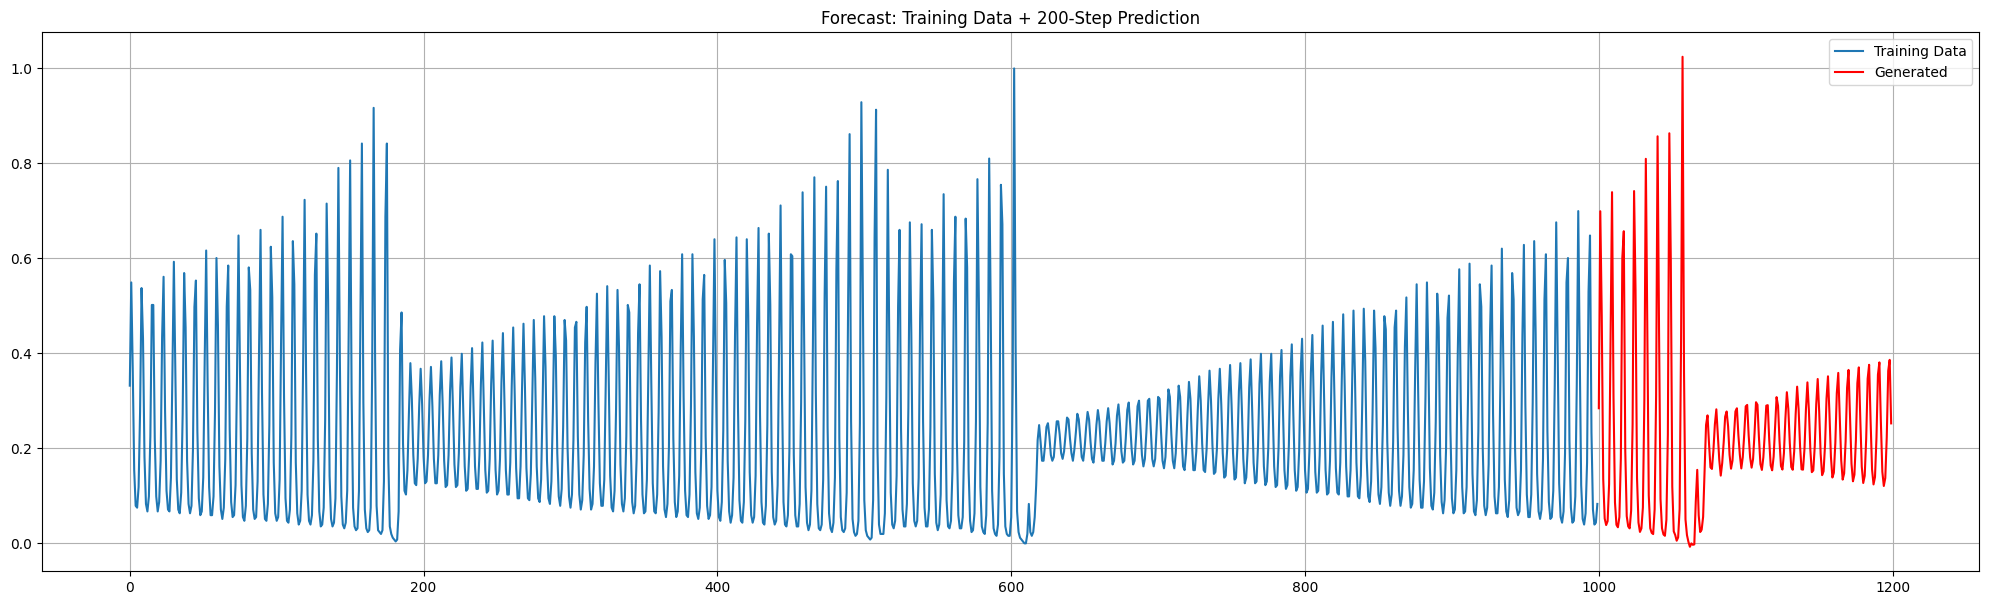

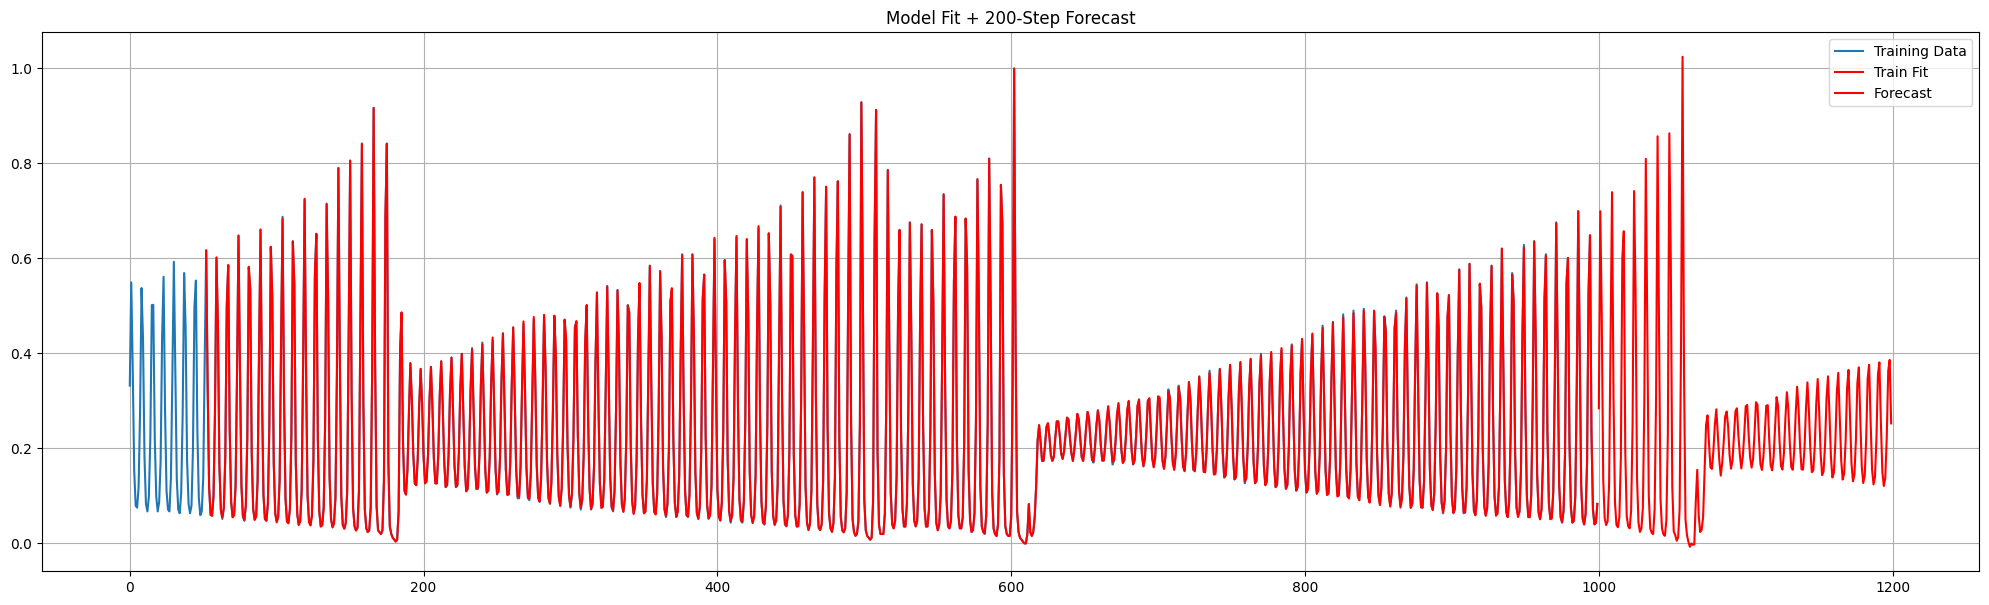

In [6]:
best_params = study.best_trial.params

dataset = LaserDataset(train_data, best_params['window_size'], transforms=[lambda x: x])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = model_cls(input_size=best_params['window_size'], hidden_size=best_params['hidden_size'])
optim = optim_cls(model.parameters(), lr=best_params['lr'])

train_model(dataloader, model, optim, loss_fn, epochs=500)
generate_predictions(model, train_data, best_params['window_size'])
generate_predictions_with_train_fit(model, train_data, best_params['window_size'])


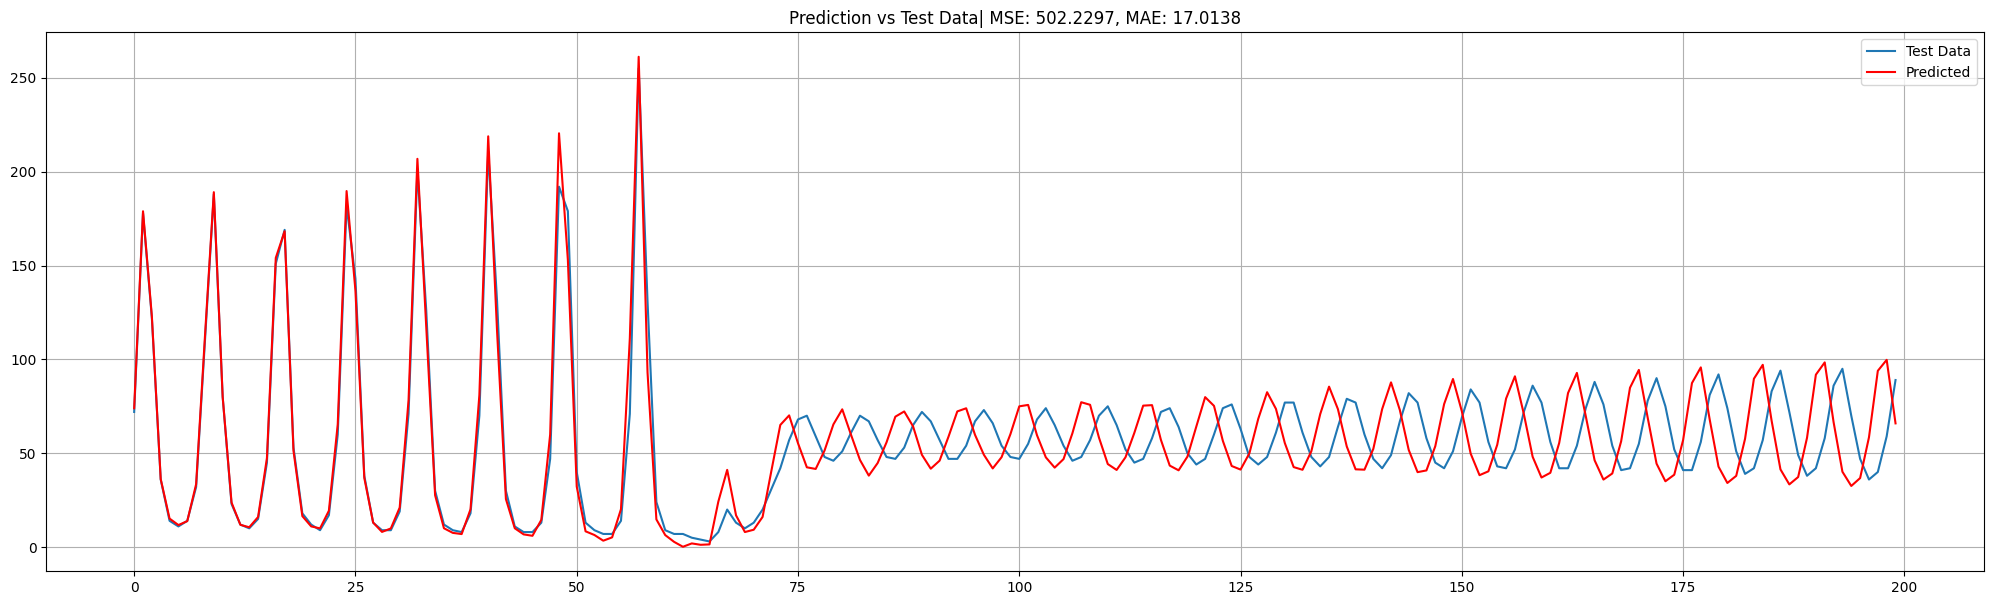

In [7]:
final_model_evaluation(model, test_data, train_data, scaler, best_params['window_size'])